Landsat 8 - Golfe de la Gonave

In [15]:
import os
import json
import glob
import tarfile

import xarray as xr
import earthpy as et 
import rasterio as rs
import rioxarray as rxr
import geopandas as gpd
import earthpy.plot as ep
import earthpy.spatial as es 
import matplotlib.pyplot as plt

from natsort import natsorted
from rasterio.plot import show


Getting all .tar files in PhD Data directory

In [16]:
for filepath in glob.iglob('F:/PhD Data/Landsat 8 OLI_TIRS C2 L1/*.tar'):
    print(filepath)

F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1GT_009047_20170422_20200904_02_T2.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1GT_009047_20180103_20200902_02_T2.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009046_20210908_20210916_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130401_20200913_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130427_20200913_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130513_20200913_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130630_20200912_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130716_20200912_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130801_20200912_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130817_20200913_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130902_20200912_02_T1.tar
F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_20130918_20200912_02_T1.tar
F:/PhD Data/Land

Retrieve Bands from .tar file and sort them

In [17]:
rs.Env(VRT_SHARED_SOURCE = 0)
path = "F:/PhD Data/Landsat 8 OLI_TIRS C2 L1/LC08_L1TP_009047_20160809_20200906_02_T1.tar"
archive = tarfile.open(path, 'r')
archive.getmembers()
band_files = []
for file in archive.getmembers():
    if (file.name).endswith('.TIF') or (file.name).endswith('MTL.json'):
        band_files.append(file)
        file.uname
        #content = archive.extractfile(file)
        #bands.append(content)
band_files = natsorted(band_files, key=lambda x: x.name)
# Remove extra pixel bands and Thermal but keep metadata
del band_files[-6:]
del band_files[9:11]

Extract Band files for temporary use

In [18]:
for file in band_files:
    archive.extract(file, path='extracted/')

Stack all bands in a list

In [19]:
bands = []

directory = 'extracted/'
# Looping over all GeoTIFF files
for i, entry in enumerate(os.scandir(directory)):
    # Tries to open .TIF file, if that fails, know we reached the .json metadata file and get that instead
    try:
        fp = entry.path
        da = rxr.open_rasterio(fp).squeeze()
        bands.append(da)
        bands[i]["Band"] = i+1
    except:
        metadata = json.load(open(entry.path))

Process and rescale bands using metadata (TOA reflectance calculation)

In [24]:
for i, band in enumerate(bands[0:-1]):
    M_p = metadata['LANDSAT_METADATA_FILE'] \
                    ['LEVEL1_RADIOMETRIC_RESCALING'] \
                    ['REFLECTANCE_MULT_BAND_{}'.format(i+1)]
    A_p = metadata['LANDSAT_METADATA_FILE'] \
                    ['LEVEL1_RADIOMETRIC_RESCALING'] \
                    ['REFLECTANCE_ADD_BAND_{}'.format(i+1)]
    toa = float(M_p) * band.values + float(A_p)
    bands[i].values = toa
del bands[-1]

Stack all bands in a dataset

In [25]:
ds_gonave = xr.concat(bands, dim='Band')

Plotting

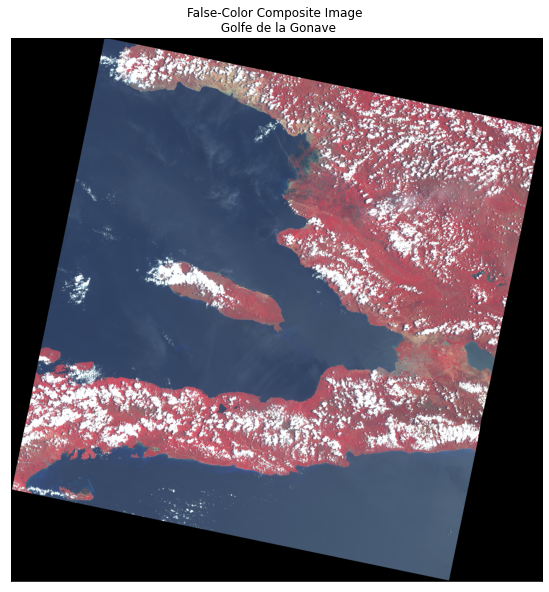

In [28]:
#ds_gonave.plot.imshow(col="Band",col_wrap=3,cmap="Greys_r")
ep.plot_rgb(ds_gonave.values, rgb=[4,3,1], title="False-Color Composite Image \n Golfe de la Gonave", stretch=True,
            str_clip=0.02)
plt.show()

Wipe extracted files for cleaning

In [23]:
for entry in os.scandir(directory):
    try:
        os.remove(entry.path)
    except:
        print('cant delete ' + entry.path + '\nfile still in use')

cant delete extracted/LC08_L1TP_009047_20160809_20200906_02_T1_B9.TIF
file still in use
